In [29]:
import numpy as np
from scipy.integrate import odeint
import scipy
from scipy import interpolate
from itertools import chain
import matplotlib.pyplot as plt
from IPython import display

# Part A

Let's first find the needed value of $a=f''(0)$ that will give us $f'(+\infty)=1$ -- this $a$ turns out to be 0.33205736;

and then integrate our 3d system of ODE to obtain $f,f',f''$ on the grid of etas.

Right value of y''(0) is [0.33205736]


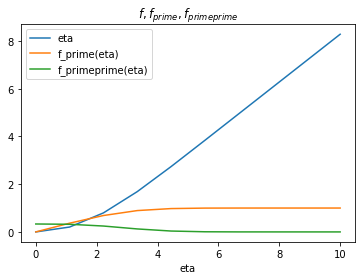

In [4]:
etas=[x for x in chain(np.linspace(0,100,10000), np.linspace(100,100000,100000))]

def righthandsidefunction(y,eta):
    return [y[1],y[2],-0.5*y[0]*y[2]]

def dydeta_at_infty(a):
    return odeint(righthandsidefunction, [0,0,a], etas)[-1][1] -1.0

a=scipy.optimize.root(dydeta_at_infty,[1.0])
print("Right value of y''(0) is", a.x)

y0=[0,0,a.x] #initial conditions
otv=odeint(righthandsidefunction, y0,etas)
f_of_etas_discretized=list(map(lambda x: x[0],otv))
fprime_of_etas_discretized=list(map(lambda x: x[1],otv))
fprimeprime_of_etas_discretized=list(map(lambda x: x[2],otv))

#U0=5
nu=15*1e-6

def f(eta):
    return interpolate.interp1d(etas, f_of_etas_discretized)([eta])[0]
def fprime(eta):
    return interpolate.interp1d(etas, fprime_of_etas_discretized)([eta])[0]
def fprimeprime(eta):
    return interpolate.interp1d(etas, fprimeprime_of_etas_discretized)([eta])[0]
def delta(x,U0):
    return np.sqrt(nu*x/U0)
def deltaprime(x,U0):
    return np.sqrt(nu/(U0*x))/2
def u(x,y,U0):
    eta=y/delta(x,U0)
    return U0*fprime(eta)
def v(x,y,U0):
    eta=y/delta(x,U0)
    return -U0*deltaprime(x,U0)*(f(eta)-fprime(eta)*eta)

def u_scaled(eta):
    return fprime(eta)
def v_scaled(eta,U0):
    return -deltaprime(x,U0)*(f(eta)-fprime(eta)*eta)


etalims=np.linspace(0,10,10)

    
plt.plot([eta for eta in etalims],[f(eta) for eta in etalims],label='eta')
plt.plot([eta for eta in etalims],[fprime(eta) for eta in etalims],label='f_prime(eta)')
plt.plot([eta for eta in etalims],[fprimeprime(eta) for eta in etalims],label='f_primeprime(eta)')
plt.xlabel('eta')
plt.title('$f,f_{prime},f_{primeprime}$')
plt.legend()
plt.show()

Now let's draw obtained wind velocities for a fixed $x=1000$ and $x=4000$, fixed $U0=5$ and different $y \in np.linspace(0,0.8,30)$; and then draw velocities for some other x;

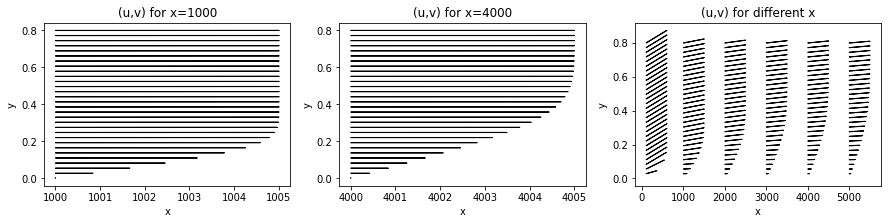

In [14]:
fig,ax=plt.subplots(1,3)
fig.set_figwidth(15)
fig.set_figheight(3)

for y in np.linspace(0,0.8,30):
    ax[0].arrow(1000,y,u(1000,y,U0=5),v(1000,y,U0=5))
    ax[1].arrow(4000,y,u(4000,y,U0=5),v(4000,y,U0=5))
    for x in [100,1000,2000,3000,4000,5000]:
        ax[2].arrow(x,y,u(x,y,U0=5)*100,v(x,y,U0=5)*100)
        

ax[0].set_title('(u,v) for x=1000')
ax[1].set_title('(u,v) for x=4000')
ax[2].set_title('(u,v) for different x')
ax[0].set_xlabel('x')
ax[1].set_xlabel('x')
ax[2].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_ylabel('y')
ax[2].set_ylabel('y')
plt.show()

We see that the third picture looks exactly as on the Wikipedia page for Blasius solution!

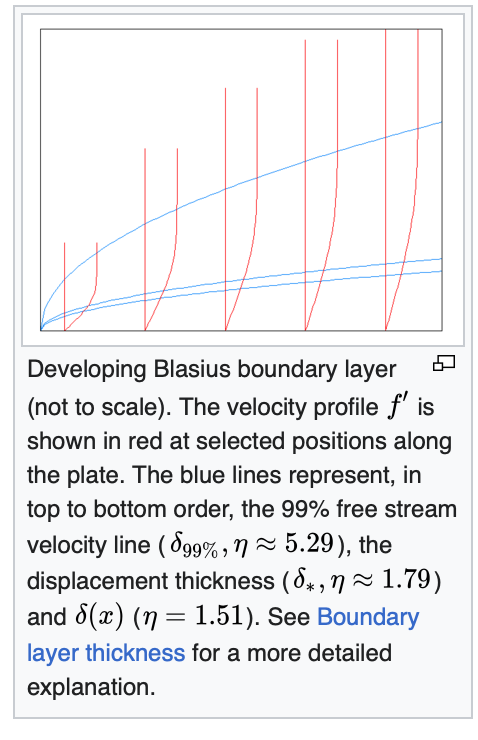

In [40]:
display.Image('blasius_wikipedia.png',width=500,height=500)

Now let' draw trajectories of the integted system and 
also the contourplot for $u(x,y)$ as a colour, depending on x and y.

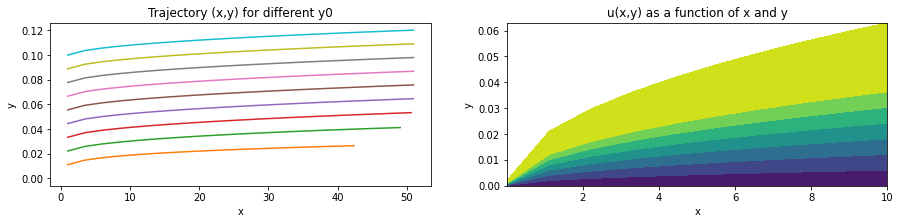

In [19]:

fig,ax=plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(3)

#trajectories
dt=0.5
for y0 in np.linspace(0,0.1,10):
    trajectoryx=[]
    trajectoryy=[]
    x=1
    y=y0
    trajectoryx.append(x)
    trajectoryy.append(y)
    for t in range(20):
        dx=u(x,y,U0=5)
        dy=v(x,y,U0=5)
        x+=dt*dx
        y+=dt*dy
        trajectoryx.append(x)
        trajectoryy.append(y)
    ax[0].plot(trajectoryx,trajectoryy)
    
    
    
#contourplot
mas_x=[]
mas_y=[]
mas_u=[]
mas_v=[]
for x in np.linspace(0.01,10,10):
    #print(x,delta(x,U0))
    mas_x.append([])
    mas_y.append([])
    for exp_eta in np.linspace(1,100000,100):
        eta=np.log(exp_eta)
        y=eta*delta(x,U0=5)
        utek=u(x,y,U0=5)
        vtek=v(x,y,U0=5)
        mas_x[-1].append(x)
        mas_y[-1].append(y)
        mas_u.append(utek)
        mas_v.append(vtek)

X=mas_x
Y=mas_y
Z=np.array(mas_u).reshape(10,-1)

ax[1].contourf(X,Y,Z)

ax[0].set_title('Trajectory (x,y) for different y0')
ax[1].set_title('u(x,y) as a function of x and y')
ax[0].set_xlabel('x')
ax[1].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_ylabel('y')
plt.show()

We see that close to the ground $u(x,y)$ is almost zero (because no slip condition), 
and then the wind speed increases up to $U_0=5$ meters per second.

# Part B

Let's integrate our system of ODE and 
see how trajectories with different initial y0 differ for drops with different diameters.

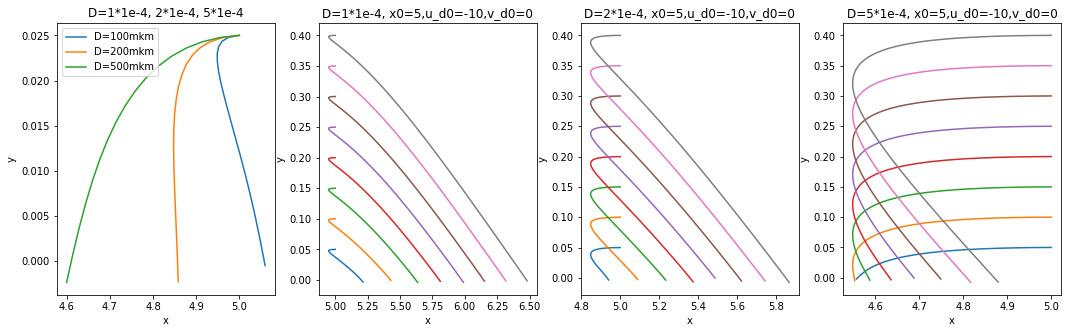

In [21]:

def get_trajectory(D,x0,y0,u_d0,v_d0,U0,mass_k=0):
    c_d=0.47
    rho_a=1.2255
    rho_d=1000
    g=9.8
    angle=1
    m_d0=rho_d*4/3*np.pi*D**3/8*(1-rho_a/rho_d)*angle


    def Fa(u_d,v_d,x,y,U0):
        u_a=u(x,y,U0)
        v_a=v(x,y,U0)
        return 0.5*c_d*rho_a*0.25*np.pi*D**2*np.sqrt((u_a-u_d)**2 + (v_a-v_d)**2)

    def Fgy(m_d):
        return -m_d*g

    def Fax(u_d,v_d,x,y,U0):
        return -Fa(u_d,v_d,x,y,U0)*(u_d-u_a)

    def Fay(u_d,v_d,x,y,U0):
        return -Fa(u_d,v_d,x,y,U0)*(v_d-v_a)


    dt=0.005
    trajectoryx=[]
    trajectoryy=[]
    x=x0
    y=y0
    u_d=u_d0
    v_d=v_d0
    trajectoryx.append(x)
    trajectoryy.append(y)
    i=0
    while y > 0:
        m_d=m_d0*np.exp(-mass_k*i*dt)
        i+=1
        #print(x,y)
        u_a=u(x,y,U0)
        v_a=v(x,y,U0)
        du_d=Fax(u_d,v_d,x,y,U0)/m_d
        dv_d=(Fay(u_d,v_d,x,y,U0)+Fgy(m_d))/m_d
        #print(x,y,u_a,v_a,du_d,dv_d)
        #print(Fay(u_d,v_d,x,y))
        #print(Fgy())
        u_d+=dt*du_d
        v_d+=dt*dv_d
        x+=dt*u_d
        y+=dt*v_d
        trajectoryx.append(x)
        trajectoryy.append(y)
    return trajectoryx,trajectoryy


fig,ax=plt.subplots(1,4)
fig.set_figwidth(18)
fig.set_figheight(5)


ax[0].set_title("D=1*1e-4, 2*1e-4, 5*1e-4")
tx,ty=get_trajectory(D=1*1e-4, x0=5,y0=0.025,u_d0=-10,v_d0=0,U0=5)
ax[0].plot(tx,ty, label='D=100mkm')
tx,ty=get_trajectory(D=2*1e-4, x0=5,y0=0.025,u_d0=-10,v_d0=0,U0=5)
ax[0].plot(tx,ty, label='D=200mkm')
tx,ty=get_trajectory(D=5*1e-4, x0=5,y0=0.025,u_d0=-10,v_d0=0,U0=5)
ax[0].plot(tx,ty, label='D=500mkm')
ax[0].legend()

ax[1].set_title("D=1*1e-4, x0=5,u_d0=-10,v_d0=0")
for y0 in np.linspace(0.05,0.4,8):
    tx,ty=get_trajectory(D=1*1e-4, x0=5,y0=y0,u_d0=-10,v_d0=0,U0=5)
    ax[1].plot(tx,ty)

ax[2].set_title("D=2*1e-4, x0=5,u_d0=-10,v_d0=0")
for y0 in np.linspace(0.05,0.4,8):
    tx,ty=get_trajectory(D=2*1e-4, x0=5,y0=y0,u_d0=-10,v_d0=0,U0=5)
    ax[2].plot(tx,ty)

ax[3].set_title("D=5*1e-4, x0=5,u_d0=-10,v_d0=0")
for y0 in np.linspace(0.05,0.4,8):
    tx,ty=get_trajectory(D=5*1e-4, x0=5,y0=y0,u_d0=-10,v_d0=0,U0=5)
    ax[3].plot(tx,ty)

ax[0].set_xlabel('x')
ax[1].set_xlabel('x')
ax[2].set_xlabel('x')
ax[3].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_ylabel('y')
ax[2].set_ylabel('y')
ax[3].set_ylabel('y')
plt.show()

On the first plot we see that that the greater the mass of the drop, 
the less is the impact of the wind on the trajectory.
So in order to obtain desired behaviour of pesticide treatment it is better to use big droplets such as 300-400 mkm.
And on the plots 2-4 we see that the impact of the hight of initial point on the trajectory also 
differs greatly when diameter differs. So in the next graph we will explore the impact of the height of 
inital point on the cone of trajectories for different wind sppeds.

Recall that if the drop is released from the nozzle at speed SpeedFromNozzle with angle $\alpha$ to the vertical axis, 
then its horizontal component is SpeedFromNozzle$\cdot \sin \alpha$, 
and vertical component is SpeedFromNozzle$\cdot \cos \alpha$;
From the nozzle drops are released at different angles and hence form the cone of trajectories.
Let's draw this cone for different $y_0=[0.5,0.35,0.2,0.1]$ and different wind speeds = [0.1, 5,10,15]
(that initiate different Blasius solutions).

I took drop exis velocity 20 meters per second based on velocities from Broumand article.

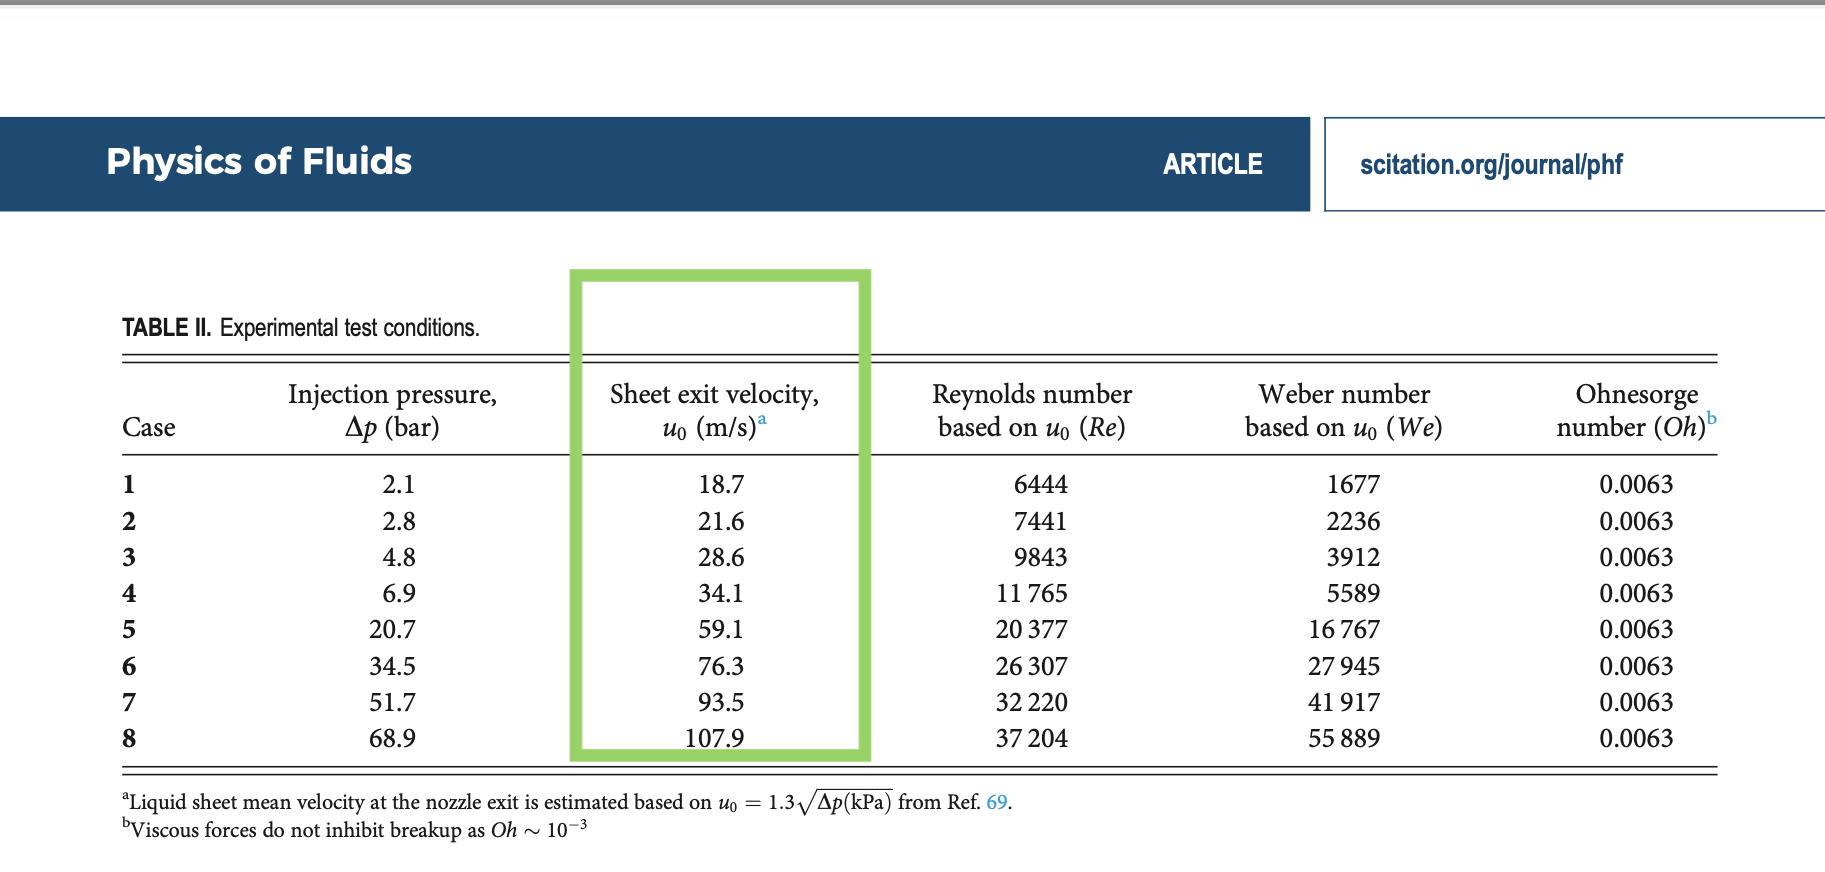

In [39]:
display.Image('drop_exit_velocity.png',width=600,height=600)

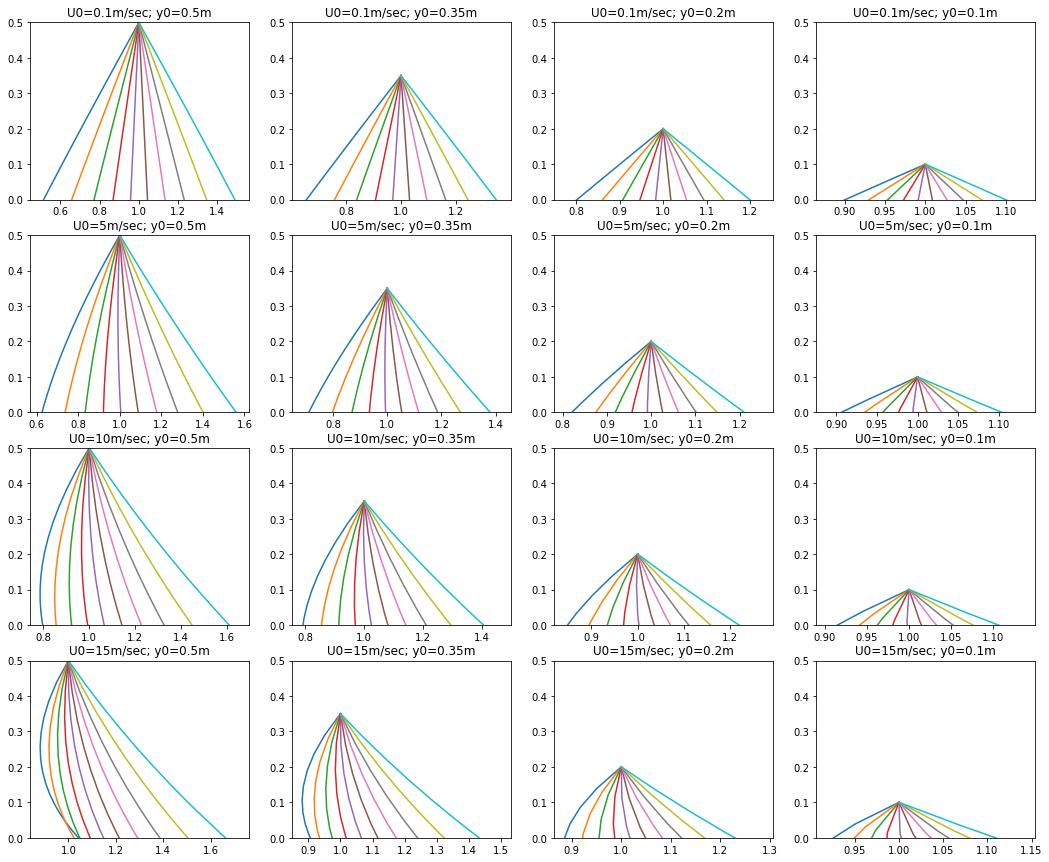

In [77]:
fig,ax=plt.subplots(4,4)
fig.set_figwidth(18)
fig.set_figheight(15)


wind_speeds=[0.1, 5,10,15]
y0s=[0.5,0.35,0.2,0.1]

SpeedFromNozzle=20

for i in range(len(wind_speeds)):
    U0=wind_speeds[i]
    for j in range(len(y0s)):
        y0=y0s[j]
        for alpha in np.linspace(-np.pi/4,np.pi/4,10):
            tx,ty=get_trajectory(D=5*1e-4, x0=1,y0=y0,u_d0=SpeedFromNozzle*np.sin(alpha),v_d0=-SpeedFromNozzle*np.cos(alpha),U0=U0)
            ax[i,j].plot(tx,ty)
            ax[i,j].set_ylim([0,0.5])
            ax[i,j].set_title("U0="+str(U0)+"m/sec; "+"y0="+str(y0)+"m")

plt.show()

We see two things. First, wind really matters and it may cause the cone to shift by 20 santimeters at speed 15 meters paer second;
And since the nozzles are located on the beam of the tractor at such a distance that the cones intersect at the middle of their ways, that is 0.5 meters,
then 0.2 meters of shift due to the wind will lead to sufficint interesection of 
the cones and hence overfertilization of the ground and addidtional costs on fertilizer itself.
And the second fact is that the higher the initial point, the greater the wind affects the trajectory cone. 
So is will be beneficial to locate the beam of the tractor as low as possible (but not to harm the crops by pushing them by the beam). 

# Part C: add evaporation

 We now will take into account the fact that due to evaporation the mass of the drop diminishes while it flies, 
 and this fact means that the plants are reached by less amount of pesticide that left the fertilizer machine (tractor of unmanned aerial vehicle). In conditions of high wind (5-8-10 m/sec), high velocity of the tractor (10-15-20 m/sec), low relative humidity of the air (< 60%) and high temperature (>20 degrees of Celsius) up to 50% of water that left the machime may evaporate! And small drops (with diameter < 200 microns) will totally evaporate before they reach the ground! Coventry area is lucky because its average wind speed is about 5 m/sec, average relative humidity of the air varies betrween 60-96% and temperature varies between 10-20 degrees, so the effect of loosing fertilizer due to evaporation will not be as detrimetntal as 50%, but it may reach 10-20%, so we need to take this into account while modeling and also when we will calculate the estimated amount of fertilizer needed. So lets study how time to full evaporation depends on the diameter of the drop and choose which diameter is good for us.

In the agriculural literature (attached, dissertation of Nadezhkina) we have the following formula to estimate total time to evaporation:
    $$T=\frac{176.4 d^2}{(1+1.92V_{wind})Deficit},$$
    
where $V_{wind}$ is the speed of wind, 
    
$T(min)$ is time to full evaporation in MINUTES, 
    
$d (milimeters)$ is the diameter of the drop, 
    
$Deficit( percents)$ is the deficit of stream elasticity.
    
For example, let's calculate time to full evaporation for a drop with diameter 100 microns = 0.1 milimeters, speed of wind 5m/sec and deficit of stream elasticity equal to 60%. And compare this time to an approximation of how much time would the drop need to reach the ground if there was no wind and no inital vertical speed and so the drop was simply falling down due to gravity: $h=\frac{gt^2}{2}$, so $t_{fall}=\sqrt{\frac{2h}{g}}$, and assume that the hight of our vehicle beam with nozzles is 0.5 meters.

In [79]:
d=0.1 #0.1mm=1e1-4=100microns
Vwind=5 #m/sec
Deficit=60 #persent
g=9.8
t_evap=176.4*d**2/((1+1.92*Vwind)*Deficit)*60  #sec
print("Time to full evaporation, sec:", t_evap)
h=0.5 #0.5m
t_fall=np.sqrt(2*h/g) #sec
print("Time to reach ground, sec:", t_fall)

Time to full evaporation, sec: 0.1664150943396227
Time to reach ground, sec: 0.3194382824999699


We see that for this diameter of drops time to fall is greater than time to evaporation! 
So no part of drop will reach the ground! 
So we need  to increase the diameter of the drop to 200 microns and also it may be benefitial
to decrease the hight of the beam with nozzles and make it 0.4 meters in order to allow the tractor to work when the wind is blowing (and the higher the beam is located, the greater the wind shifts the droplets, as we have seen in the pictures above).


In [80]:
d=0.2 #0.2mm=2e1-4=200microns
Vwind=5 #m/sec
Deficit=60 #persent
t_evap=176.4*d**2/((1+1.92*Vwind)*Deficit)*60  #sec
print("Time to full evaporation, sec:", t_evap)
h=0.5 #0.4m
t_fall=np.sqrt(2*h/g) #sec
print("Time to reach ground, sec:", t_fall)

Time to full evaporation, sec: 0.6656603773584908
Time to reach ground, sec: 0.3194382824999699


Now we see that the situation is better: some part of the drop will reach the ground. 
In fact, from the literature we can find that recommended drop size is 200-400 microns. 
Smaller drops will evaporate, and larger drops will not provide good and smooth coverage of the region with the fertilizer.

Now use the Mansurov's formula to estimate evaporation (in percents}:

$$E_{evap}= \frac{100 Deficit (1+1.92 V_{wind} t d^2)}{10584 },$$
where Evap is the fraction of evaporated drop (in percents), 

where 

$V_{wind}$ is the speed of wind, 
    
$T(min)$ is time to full evaporation in seconds, 
    
$d (milimeters)$ is the diameter of the drop, 
    
$Deficit( percents)$ is the deficit of stream elasticity.
    

For example, if $V_{wind}$ =2 m/sec, d=300 microns=0.3mm, $t=3sec$, $deficit=60$,


then $E_{evap}=100 \cdot 60(1+1.92\cdot2)\cdot3/10584\cdot0.3\cdot0.3=0.656$.

So more than half of a drop has evaporated!

In [351]:
100*60*(1+1.92*2)*2.66/10584*0.3*0.3

0.6568571428571429

Now lets introduce $k$ such that $m(t)=m_0e^{-kt}$, where coefficient $k$ is responsible for evaporation and hence to drop mass reduction; 


and let's take k such that the ground will be reached by a frop with $m=0.7m_0$ of initial drop.

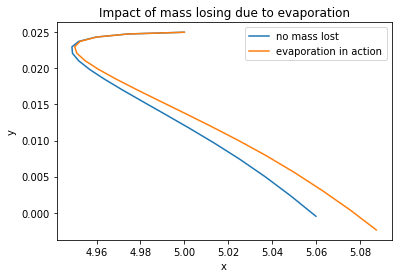

In [27]:

k=-np.log(0.85)/2*50

tx,ty=get_trajectory(D=1*1e-4, x0=5,y0=0.025,u_d0=-10,v_d0=0,U0=5)
plt.plot(tx,ty,label='no mass lost')


txk,tyk=get_trajectory(D=1*1e-4, x0=5,y0=0.025,u_d0=-10,v_d0=0,U0=5,mass_k=k)
plt.plot(txk,tyk, label='evaporation in action')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Impact of mass losing due to evaporation')
plt.legend()
plt.show()

We see that evaporation not only effects the amount of pecticide 
that reaches the ground but it also slightly changes the trajectory of the drops! 

So drops become lighter and suffer more from shifts due to the wind.

# Part D

# Drop size distribution

As said in the provided in session 5 cambridge group report on properties of drops, 
the distribution of the drops  is lognormal. I found the possible explanation of this emperical fact. 
Assuming that the appearance of different size in aerozol follows 
exponential distribution (this exponential distribution comes
from exponential growth of instabilities in layers of liquid and streams preceeding the drop decay),
we have that formula binding the change $dD/D$ of drop size in diapason $dD$ in aerosol 
with respect to its representative diameter $D$, depends on the constant speed of the growth of diversity of the drop size $\phi$ in the infinitesimally small time interval $d\tau$ as follows: 
$$\frac{dD}{D}=\phi d\tau$$;
Here $\tau$ corresponds to moment $t$, normed by the characteristic time of destruction: $\tau=\frac{t}{t_b}$;
When drops destruct, they break into smaller drops; Integrating the equation, we obtain that the normalized time interval, needed for creation of drops in the fixed class k of drop sizes is 
$$\tau_k=\frac{\ln(D_k)-\ln(D_{n0.5})}{\phi}$$, 
where $D_{n0.5}$ is a characteristic diameter with respect to range of sizes in aerozol, which in case of lognormal law is the median diameter (and in fertilizing machines they also write the median diameter of the drops!); 
After this we assume that the probability of addition of an infinitely small amount of drops into the class in the result of their size change is 
$$\frac{d n_k}{N}=dp_k$$,
where $N$ is the sample size, and $dp_k$ is the infinitesimally small change of the value of frequency probability. And the last equation transforms this distribution of drop sizes by classes into a distribution of times. Due to the random nature of droplet formation, the distribution of times is normal. Therefore, assuming that the standard normal distribution, expresses the random nature of changes in the probability of each size class, the rate of probability change of a certain size class k is given by 
$$\frac{dp_k}{d\tau}=\frac{1}{\sqrt{2\pi}}e^{-\frac{-\tau_k^2}{2}}$$

Using probability density function
$$f(D)=\frac{dp_k}{dD}=\frac{dp_k}{\phi D d\tau}$$

we result in lognormal function

$$f(D)=\frac{ exp^{    \frac{-(\ln(D/D_{n0.5}))^2} {2\phi^2}   }     }{\phi D\sqrt{2}}$$

They in the report also provided a formula by Dombrowski and Johns for the drop size:
$$d_D= \left[ {\frac{3\pi}{\sqrt{2}}} \right] ^{1/3} d_L \left[ {1+\frac{3\mu}{ ({\rho \sigma d_L})^{1/2}  }} \right] ^{1/6},$$
    
where $d_D$ isn droplet diameter, $\mu$ is liquid's dunamic viscosity, $\rho$ is the liquid's density, $\sigma$ is the surface tension coefficient, and $d_l$ is the ligament diameter,
$$d_L=0.9614 \left[ \frac{K^2 \sigma^2}{\rho_a \rho U^4} \right]^{1/6} \left[
1 + 2.6\mu^3 \sqrt{\frac{K\rho_a^4U^7}{72\rho^2\sigma^5}}\right]^{1/5},$$
where $K$ is the liquid sheet thickness times distance from the source, $\rho_a$ is the density of the surrounding air, and $U$ is the sheet velocity.
   
We have $\rho_a=1 \frac{kg}{m^3}$, $\rho=1000\frac{kg}{m^3}$, $\sigma=0.025 \frac{N}{m}$, $\mu=0.0009 \frac{Pa}{sec}$, $U_0=20 \frac{m}{sec}$,$D=0.0001 m$, 

In [97]:
rho_a=1
rho=1000
sigma=0.025
mu=0.0009
U=20
K=0.0001
d_L=0.9614*((K**2*sigma**2)/(rho_a*rho*U**4))**(1/6)*(1+2.6*mu**3*np.sqrt((K*rho_a**4*U**7)/(72*rho**2*sigma**5)))**(1/5)
d_D=(3*np.pi/np.sqrt(2))*(1/3)*d_L*(1+(3*mu)/(np.sqrt(rho*sigma*d_L)))**(1/6)
print("d_D=",d_D)

d_D= 0.0012487213213833465


We see $d_D=12e-4$, it is bigger than our $5e-4$ used as droplet sized for fertilization, but is sounds not absurd.

Let's draw a sample distribution of a lognormal random variables which produces drop sizes from 100 miscrons to 300 miscrons (that is what we need for fertilization).

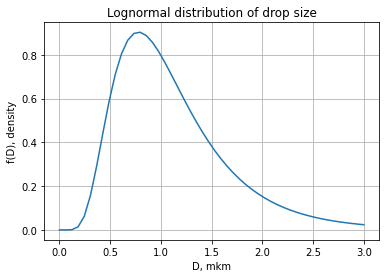

In [113]:
from scipy.stats import lognorm
mas_x=np.linspace(0,3)
plt.plot(mas_x, lognorm.pdf(mas_x, s=1/2,loc=0,scale=1))
plt.title('Lognormal distribution of drop size')
plt.grid()
plt.xlabel('D, mkm')
plt.ylabel('f(D), density')
plt.show()

And now let's present the distributions that are found in Cambridge report about drop size properties.

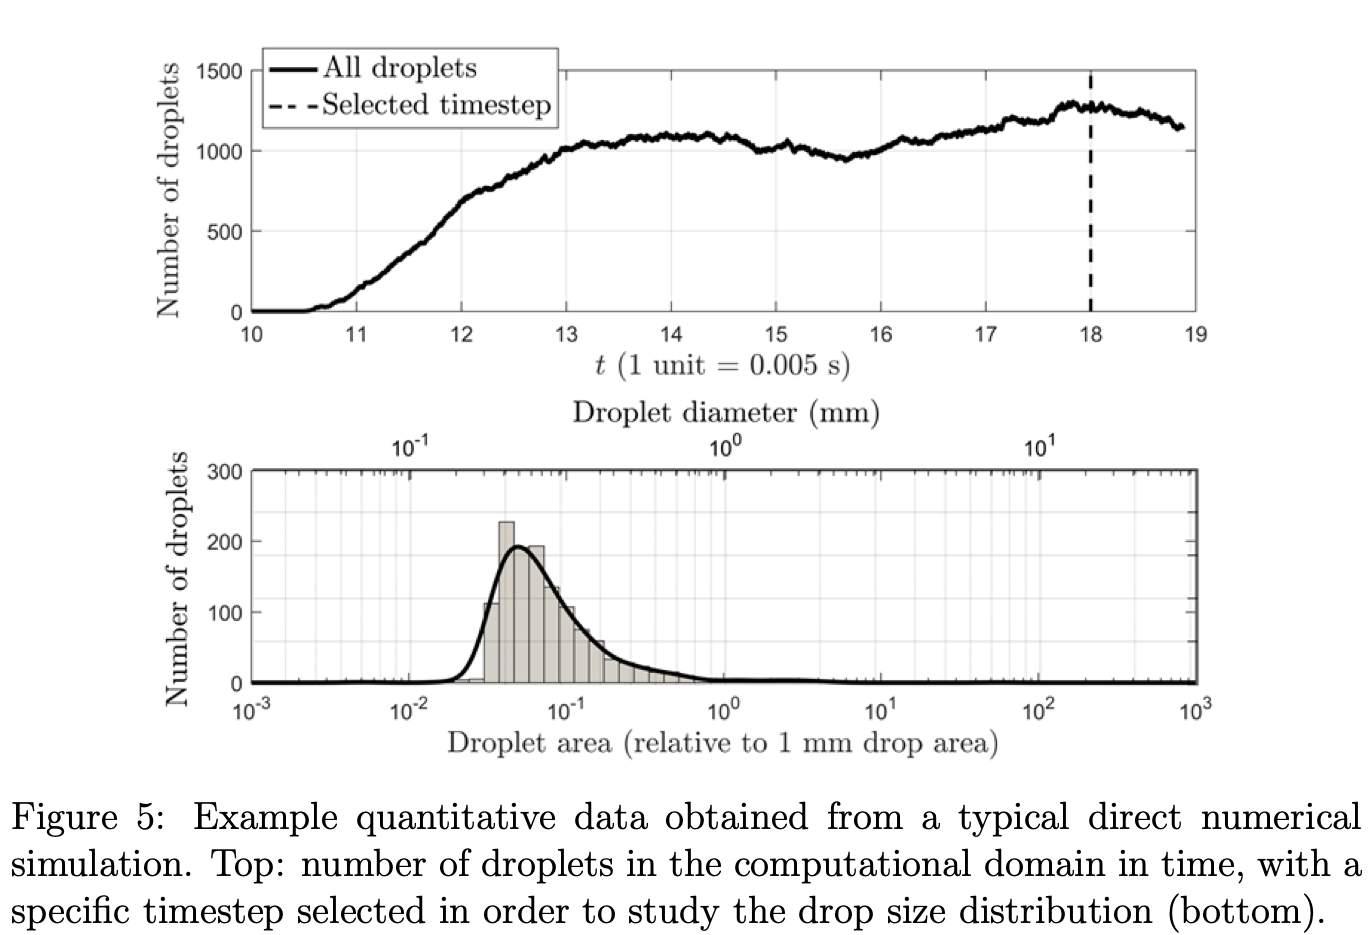

In [34]:
display.Image('drop_distrib1.png',width=500,height=500)

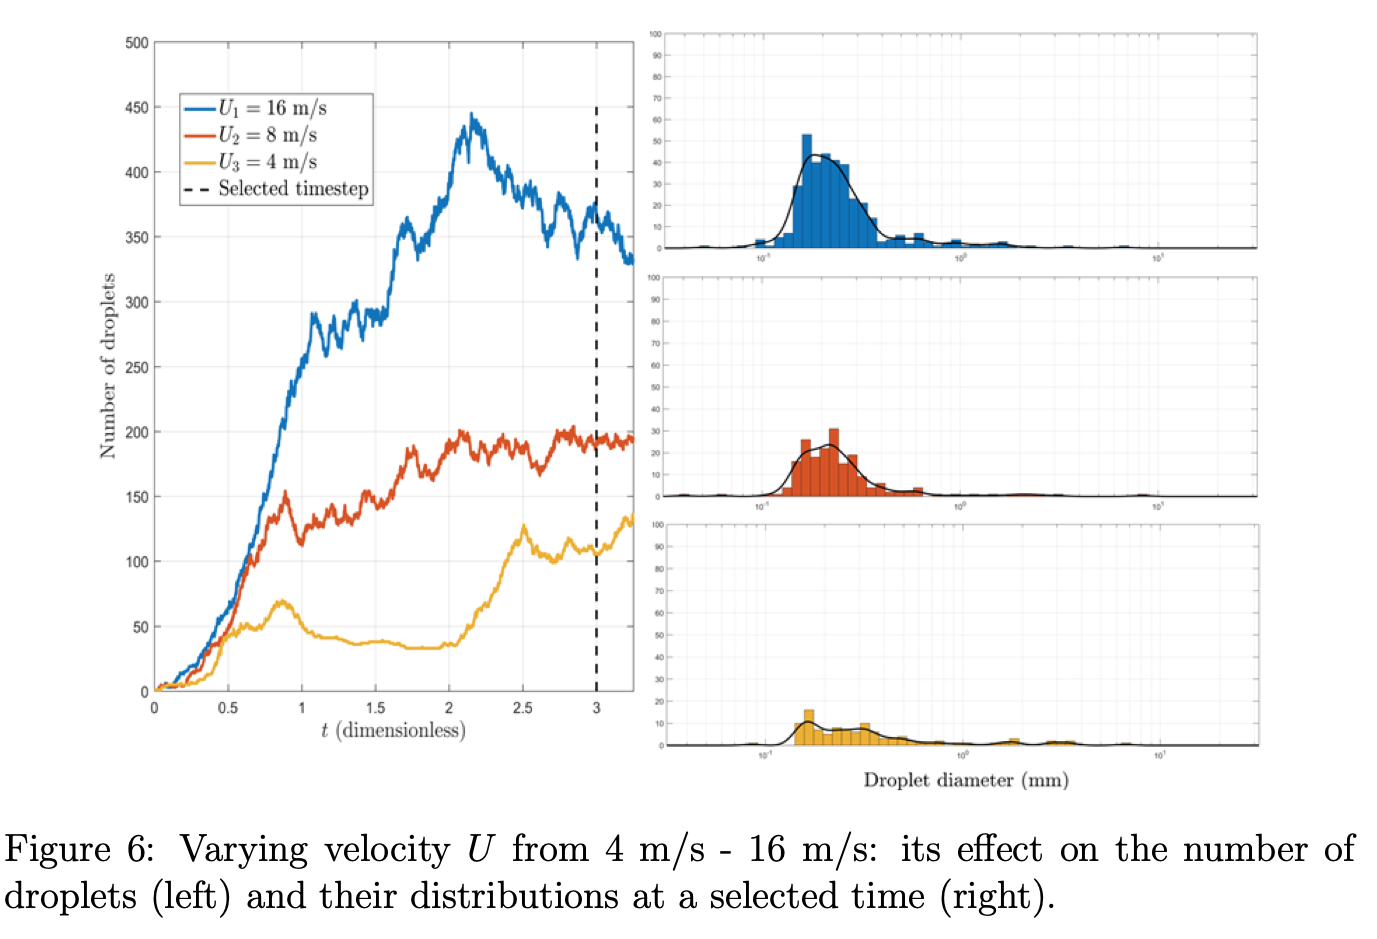

In [37]:
display.Image('drop_distrib2.png',width=900,height=700)

Now let's discuss sutable pesticide concentration and composition, on the example of sunflowers.
There are two kinds of pesticides that can be used when the sunflowers are alredy plants, not seeds: 
    they are either those who make sunflowers grow bigger and have better seeds for future sunflower oil,
    or those that kill weeds but make no harm to sunflowers.
    
One of the most widespread pesticide against weeds that is used for sunflowers is called Beccard 150 KE; 
it contains metolachlor, terbutylazine, imazetapir, tribenuron-methyl, hizalofop-p-etil and quizalophop-p-tephuryl;
and the active chemical is 125 grams per liter.

For making the crop better and richer, it is also worth considering enricing the soil 
with carbamide and ammonium nitrate. Typical percentage is 28%, 
but in 100 liters there will be 36 kg of fertilizer, because 100 liters of water weight 128 kg. 
We need to add water to use the fertilizer: 3 parts of water on one part of fertilizer.

We need to use 300 liters per hectar in order to have 40 droplets per squared santimeter; 
the field is 40 hectars; so we need 12000 liters; 
a pack of 10 liters of Baccard 125 costs 133 pounds; so we need 1200*133 =159.6 
thousands of pounds to pay for each treatment of the field with this pesticide.
If we take into account loosing pesticide due to evaportaion and shifting by the wind, 
we will need approximately 20% much fertilizer, so the cost wiil be 191.52k pounds.

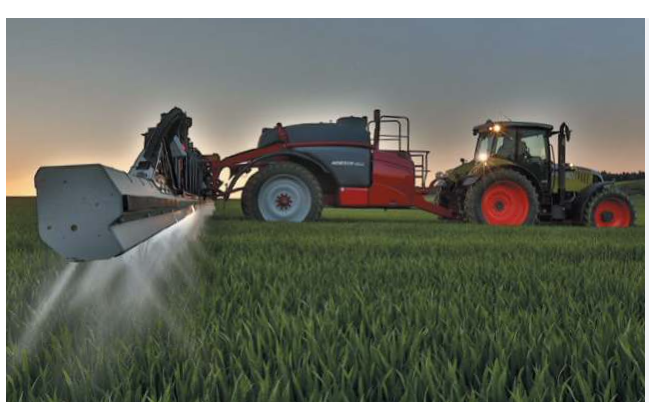

In [41]:
display.Image('tractor.png',width=500,height=500)

And now let's summarize all aspects that we found to be important if we want to use pesticides
to fertilize crops in West Midlands.

0) Do not treat the filed in bad weather conditions! Wind greatet that 5-8 meters/sec, 
or temperature greater than 20 Celsius, or hunidity less that 60% is bad weather!

1) Use injector nozzles, not slot sprayers, because injector nozzles generate droplets of 
greater size which are therefore less prone to being shifted by wind, 
and therefor lead to less losses due to wind and also enable the tractor to work with (not very strong) wind.
For example, if the hight of the nozzle is greater than 1 meter, the speed greater than 1 
meter per second and the nozzle is not injector - than 50% of drops will not reach the ground!

2) Read carefully the techical instructions for the nozzles, understand that the color of 
the nozzle is responsible for the drop size. Use drop sizes as 200-400 miscrons,
they are optimal for wind like 5 meters per second, as in West Midlands.
3)Not drive your tractor too fast, because there will be turbulent zone behind the tractor, 
and pesticinde will be attracted there, and there is risk for the crops behind the tractor to got burned by the pesticide.

4) Not neglect keeping your fertilizing equipment (a pomp, for example) in good condition 
and do nesessary renovation of equipment and nozzles, because old tired nozzles will give uneven coverage of the field.

5) Keep the beam with the nozzles at height 50-50 santimeters above the ground, if higher - 
the wind will have more effect as we have seen that the higher the nozzle is located, 
the more the wind shifts even big droplets.

6) Be ready that some percentage of droplets will evaporate - so you will need some more pesticide 
to treat the entire field than it may seem at first sight.

7) If possible buy a tractor that has compensator for vertical oscillations of the beam - because vertical oscillations affect very badly the trajectories of drops - and if the tractor is riding by a hummock, the konuses are colliding and the coverage of the field becomes uneven.

